<a href="https://colab.research.google.com/github/DongDong-Zoez/pytorchAI/blob/main/FSL/iamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Library

In [ ]:
import pandas as pd
import numpy as np
import math
import random
import os
from torch import nn
import torch
import cv2
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import random
from torchsummary import summary
import torch.nn.functional as F

In [ ]:
# Get the data directory paths
faces = '/content/gdrive/MyDrive/CV learning/Siamese/dataset/olivetti_faces.npy'
faces_targets = '/content/gdrive/MyDrive/CV learning/Siamese/dataset/olivetti_faces_target.npy'

In [ ]:
face_images = np.load(faces)
face_labels = np.load(faces_targets)

print(f'Number of images: {face_images.shape[0]}')
print(f'The size of image: {face_images.shape[1]} x {face_images.shape[2]}')

Number of images: 400
The size of image: 64 x 64


#Build Face Dataset

In [ ]:
WIDTH, HEIGHT = 64, 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([HEIGHT, WIDTH]),
    #transforms.ColorJitter(contrast=0.5, hue=0.25),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                  
])


class FaceDataset(Dataset):
    def __init__(self, image_path=faces, label_path=faces_targets, transform=transform):
        self.images = np.load(image_path)
        self.labels = np.load(label_path)
        self.label_wise_indices = dict()
        self.pair_images, self.pair_labels = self.generate_image_pairs(self.images, self.labels)
        self.transforms = transform

    def generate_image_pairs(self, images, labels):
        # Generate index for each label
        unique_labels = np.unique(labels)
        for label in unique_labels:
            self.label_wise_indices.setdefault(label, [index for index, curr_label in enumerate(labels) if label == curr_label])
        
        # Generate image pairs and labels
        pair_images = []
        pair_labels = []
        for index, image in enumerate(images):
            pos_indices = self.label_wise_indices.get(labels[index])
            pos_image = images[np.random.choice(pos_indices)]
            pair_images.append((image, pos_image))
            pair_labels.append(0)

            neg_indices = np.where(labels != labels[index])
            neg_image = images[np.random.choice(neg_indices[0])]
            pair_images.append((image, neg_image))
            pair_labels.append(1)

        return np.array(pair_images), np.array(pair_labels)

    def processing(self, image):
        if self.transforms:
            image = self.transforms(image)
        return image

    def __getitem__(self, idx):
        image1 = self.pair_images[idx,...][0]
        image2 = self.pair_images[idx,...][1]

        image1 = self.processing(image1)
        image2 = self.processing(image2)

        label = torch.tensor(self.pair_labels[idx])

        return image1, image2, label

    def __len__(self):
        return self.pair_images.shape[0]

tensor([1, 0, 0, 0, 1, 1, 1, 1])


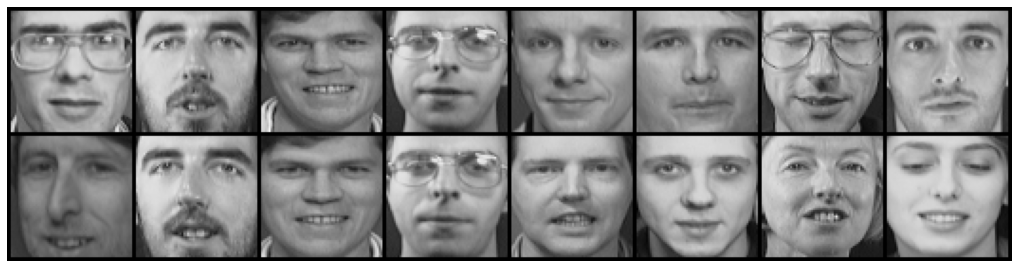

In [ ]:
face = FaceDataset()

def imshow(album):
    album = np.transpose(album, [1,2,0])
    plt.figure(figsize=(18,18))
    plt.axis('off')
    plt.imshow(album)

def display_image(dataset):
    dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=8)
    image1, image2, label = next(iter(dataloader))
    concatenated = torch.cat([image1, image2], dim=0)
    album = torchvision.utils.make_grid(concatenated, nrow=8)
    imshow(album)
    print(label)

display_image(face)

#Siamese Network

In [ ]:
class Siamese(nn.Module):
    def __init__(self):
        super(Siamese, self).__init__()

        num_conv = 4
        out_channels = [64,128,128,256]
        kernel_size = [3,3,3,3]
        pad = [int(math.floor(kernel_size[i] - 1)/2) for i in range(len(kernel_size))]

        self.layers = nn.Sequential()
        for i in range(num_conv):
            if i == 0:
                self.layers.add_module(f'conv{i}', nn.Conv2d(1,out_channels[i],kernel_size[i],1,pad[i]))
                self.layers.add_module(f'maxpool{i}', nn.MaxPool2d(2))
                self.layers.add_module(f'ReLU{i}',nn.ReLU())
                #self.layers.add_module(f'dropout{i}', nn.Dropout(0.3))
            else:
                self.layers.add_module(f'conv{i}', nn.Conv2d(out_channels[i-1],out_channels[i],kernel_size[i],1,pad[i]))
                self.layers.add_module(f'maxpool{i}', nn.MaxPool2d(2))
                self.layers.add_module(f'ReLU{i}',nn.ReLU())
                #self.layers.add_module(f'dropout{i}', nn.Dropout(0.3))

        self.features = nn.Sequential()
        #self.features.add_module(f'dense1',nn.Linear(256*4*4,4096))
        #self.features.add_module(f'ReLU', nn.ReLU())
        self.features.add_module(f'dense2',nn.Linear(out_channels[-1]*4*4,1024))
        self.features.add_module(f'Sigmoid', nn.Sigmoid())

        self.out = nn.Sequential()
        self.out.add_module(f'output', nn.Linear(1024,1))
        self.out.add_module(f'Sigmoid', nn.Sigmoid())
    
    def sister(self, x):
        
        x = self.layers(x)
        x = x.view(x.size(0),-1)
        x = self.features(x)

        return x

    def dissimilarity(self, x1, x2):

        return F.pairwise_distance(x1, x2, keepdim = True)


    def forward(self, anchor, compare):

        anchor = self.sister(anchor)
        compare = self.sister(compare)
        dist = self.dissimilarity(anchor, compare)
        #out =  self.out(dist)

        return dist

net = Siamese()
net.cuda()
summary(net, [(1,64,64),(1,64,64)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]             640
         MaxPool2d-2           [-1, 64, 32, 32]               0
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
              ReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]         147,584
         MaxPool2d-8            [-1, 128, 8, 8]               0
              ReLU-9            [-1, 128, 8, 8]               0
           Conv2d-10            [-1, 256, 8, 8]         295,168
        MaxPool2d-11            [-1, 256, 4, 4]               0
             ReLU-12            [-1, 256, 4, 4]               0
           Linear-13                 [-1, 1024]       4,195,328
          Sigmoid-14                 [-

#Loss function

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, dist, label):

        distSquared = torch.square(dist)
        marginSquared = torch.square(torch.clamp(self.margin - dist, min=0.0))
        loss = torch.mean(label * marginSquared + (1 - label) * distSquared)

        return loss

#Train

In [ ]:
from tqdm.utils import disp_trim
from torch import optim
import torch.nn as nn
import torch
from tqdm import tqdm

def train(net, device, loss_func=ContrastiveLoss(), epochs=300, batch_size=128, lr=0.001):

    face = FaceDataset()
    data_loader = torch.utils.data.DataLoader(dataset=face, batch_size=batch_size, shuffle=True)

    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = loss_func

    best_loss = float('inf')

    net.train()
    for epoch in tqdm(range(epochs)):
        for image1, image2, label in data_loader:
            optimizer.zero_grad()

            image1 = image1.to(device=device, dtype=torch.float32)
            image2 = image2.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.float32)
            label = label[:, None]

            dist = net(image1, image2)

            loss = criterion(dist, label)
            # print('Loss/train', loss.item())

            if loss < best_loss:
                best_loss = loss
                torch.save(net.state_dict(), '/content/gdrive/MyDrive/Face_model.pth')

            loss.backward()
            optimizer.step()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Siamese()
#net.load_state_dict(torch.load('/content/gdrive/MyDrive/Face_model.pth'))
net.to(device)
train(net, device)

100%|██████████| 300/300 [02:04<00:00,  2.41it/s]


#Test

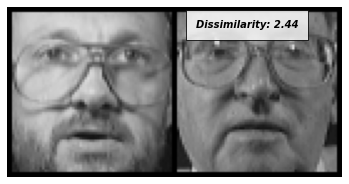

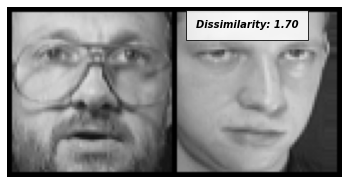

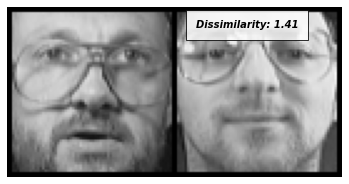

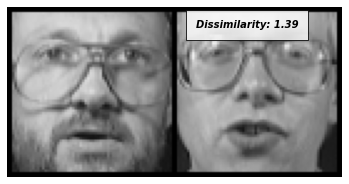

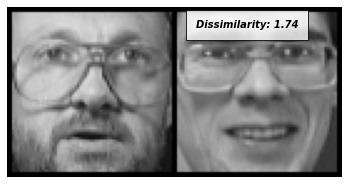

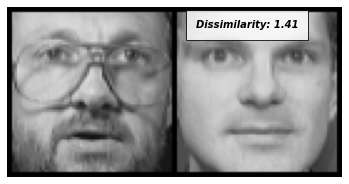

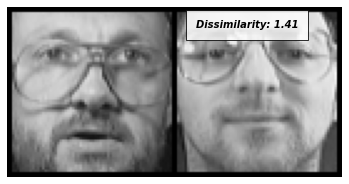

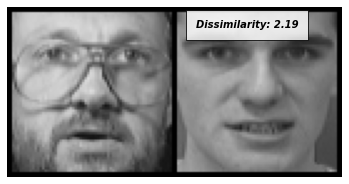

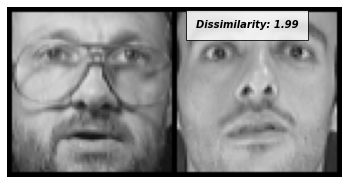

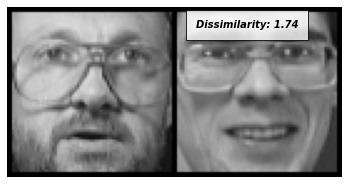

In [ ]:
import torchvision

face = FaceDataset()

test_dataloader = torch.utils.data.DataLoader(face, shuffle=True, batch_size=1)

dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

def imshow(img,text=None,should_save=False): 

    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    dist = net(x0.cuda(),x1.cuda())
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(dist.item()))